In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.integrate import odeint as scp_odeint
#from video_image.formats_conversion import mplib_gif_wrapper
from functools import partial
import torchvision
from torch.utils.data import DataLoader,TensorDataset
from ipywidgets import interact
from tqdm import tqdm
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Motivation

## General problem

\begin{equation}
    J:X \times P \rightarrow \Re
\end{equation}
    
\begin{equation}
     G:X \times P \rightarrow X
\end{equation}

Where X and P might be scalars, vectors or time dependent functions

## Specific examples that adhere to this formulation

### NN Learning, least squares regression

\begin{array}{lc}
\mbox{J}: \underset{p}{\mbox{minimize}} & \sum(x_{Data}-\hat{x}(x_{input},p))^{2}  \\
\end{array}
\begin{array}{lm}
\mbox{G}: &   \begin{cases} 
      \hat{x} = \sigma(Wx_{k})  \\
      x_{k} = \sigma(W_{k}x_{k-1}) \\
      \vdots \\
      x_{2} = \sigma(W_{2}x_{1})\\
      x_{1} = \sigma(W_{1}x_{input}) \\
   \end{cases} \\
\end{array}

### Optimal control, LQR controller

\begin{array}{lc}
\mbox{J}: \int_{0}^{tf}1/2(x^{*}Qx+u^{*}Ru)d\tau+1/2x(t_{f})^{*}Q_{f}x(t_{f})  \\
\end{array}
\begin{array}{lm}
\mbox{G}: & \dot{x} = Ax+Bu
\end{array}

### Inverse problems, seismic tomography

\begin{array}{lc}
\mbox{J}: \sum_{sensor data} ||x_{jreading,\tau}-x_{j}(t=\tau)||^{2}   \\
\end{array}
\begin{array}{lm}
\mbox{G}: & \ddot{x} = A(m)x+b(m) \\
I.C & B.C
\end{array}

## Forward derivative

## General derivation vector states

\begin{array}{lc}
\underset{p}{\mbox{min}} & J(x,p) =  f(x,p)   \\
\end{array}
\begin{array}{lc}
\mbox{subject to} & g(x,p) = 0 
\end{array}

\begin{array}{l}
\mbox{with } x\in\Re^{nx},p\in\Re^{np} \\
g: \Re^{nx}\times\Re^{np}\rightarrow \Re^{nx} \\
f: \Re^{nx}\times\Re^{np}\rightarrow \Re \\
\mbox{being } \partial_{x}g \mbox{ non singular}
\end{array}

\begin{array}{lc}
 d_{p}J =  \partial_{p}f +\partial_{x}f\partial_{p}x   \\
 \partial_{x}g\partial_{p}x=-\partial_{p}g
\end{array}

\begin{array}{l}
 d_{p}J = \partial_{p}f -\partial_{x}f\partial_{x}g^{-1}\partial_{p}g  
\end{array}

\begin{equation}
-\partial_{x}f\partial_{x}g^{-1}=\lambda^{T}\rightarrow \underset{adjoint \quad system}{\partial_{x}g^{T}\lambda = -\partial_{x}f}
\end{equation}

\begin{array}{lc}
\underset{p}{\mbox{min}} & J_{aug}(x,p) = f(x,p) + \lambda^{T}g(x,p)  \\
\end{array}


\begin{equation}
d_{p}J_{aug} = \partial_{p}f+\partial_{x}f\partial_{p}x+\lambda^{T}(\partial_{p}g+\partial_{x}g\partial_p{x})
\end{equation}

\begin{equation}
d_{p}J_{aug} = \partial_{p}f +\lambda^{T}\partial_{p}{g} + (\partial_{x}f+\lambda^{T}\partial_{x}g)\partial_{p}x
\end{equation}

\begin{equation}
\partial_{x}g^{T}\lambda = -\partial_{x}f
\end{equation}

## Derivation for vector states when objective only depends on the last state, Neural nets, discrete odes ....

\begin{array}{lc}
\underset{p}{\mbox{minimize}} & J(x_{T},p)  \\
\end{array}

\begin{array}{lcm}
\mbox{subject to} & g(x,p) = 0 = &   \begin{cases} 
      g(x_{T},x_{T-1},p) = 0  \\
      g(x_{T-1},x_{T-2},p) = 0 \\
      \vdots \\
      g(x_{2},x_{1},p) = 0\\
      g(x_{1},x_{0},p) = 0 \\
      g(x_{0},p) = 0
   \end{cases} \\
\end{array}

\begin{equation}
J_{aug}(x_{T},p) = J(x_{T},p) + \lambda_{T}g(x_{T},x_{T-1},p) + \lambda_{T-1}g(x_{T-1},x_{T-2},p) \ldots \lambda_{1}g(x_{1},x_{0},p)+ \lambda_{0}g(x_{0},p)
\end{equation}

\begin{equation}
d_{p} J_{aug} = \partial_{p} J + \partial_{x}J \partial_{p}x+
\lambda_{T}(\partial_{x_{T}}g_{T}d_{p}x_{T} + \partial_{x_{T-1}}g_{T}d_{p}x_{T-1}+\partial_{p}g_{T})+
\lambda_{T-1}(\partial_{x_{T-1}}g_{T-1}d_{p}x_{T-1} + \partial_{x_{T-2}}g_{T-1}d_{p}x_{T-2}+\partial_{p}g_{T-1})+
\ldots
\lambda_{1}(\partial_{x_{1}}g_{1}d_{p}x_{1} + \partial_{x_{0}}g_{1}d_{p}x_{0}+\partial_{p}g_{1})+
\lambda_{0}(\partial_{x_{0}}g_{0}d_{p}x_{0} + \partial_{p}g_{0})
\end{equation}

\begin{equation}
d_{p} J_{aug} = \partial_{p} J +
(\partial_{x}J+\lambda_{T}\partial_{x_{T}}g_{T})d_{p}x_{T}+
(\lambda_{T}\partial_{x_{T-1}}g_{T}+\lambda_{T-1}\partial_{x_{T-1}}g_{T-1})d_{p}x_{T-1}
\ldots
(\lambda_{1}\partial_{x_{0}}g_{1}+\lambda_{0}\partial_{x_{0}}g_{0})d_{p}x_{0}+
\lambda_{T}\partial_{p}g_{T}+\lambda_{T-1}\partial_{p}g_{T-1}+\ldots +
\lambda_{1}\partial_{p}g_{1}+
\lambda_{0}\partial_{p}g_{0}
\end{equation}

\begin{array}{lm}
\mbox{backward/adjoint system} & \begin{cases}
        \partial_{x}J+\lambda_{T}\partial_{x_{T}}g_{T} = 0 \\
        \lambda_{T}\partial_{x_{T-1}}g_{T}+\lambda_{T-1}\partial_{x_{T-1}}g_{T-1} =0 \\
        \vdots \\
        \lambda_{1}\partial_{x_{0}}g_{1}+\lambda_{0}\partial_{x_{0}}g_{0} = 0 \\
        \end{cases} \\
\end{array}

\begin{array}{lm}
\mbox{Gradient} & \begin{equation}
        d_{p} J_{aug} = \partial_{p} J +
        \lambda_{T}\partial_{p}g_{T}+\lambda_{T-1}\partial_{p}g_{T-1}+\ldots +
        \lambda_{1}\partial_{p}g_{1}+
        \lambda_{0}\partial_{p}g_{0}
        \end{equation}
\end{array}

\begin{array}{lm}
\mbox{forward/state system} &   \begin{cases} 
      g(x_{T},x_{T-1},p) = 0  \\
      g(x_{T-1},x_{T-2},p) = 0 \\
      \vdots \\
      g(x_{2},x_{1},p) = 0\\
      g(x_{1},x_{0},p) = 0 \\
      g(x_{0},p) = 0
   \end{cases} \\
\end{array}

## General derivation time dependent states

\begin{array}{lc}
\underset{p}{\mbox{minimize}} & J(x(t),p) = \int_{0}^{T} f(x(t),p) \,dx  \\
\end{array}

\begin{array}{lc}
\mbox{subject to} & \begin{cases} 
      g(\dot{x},x,p) = 0  \\
      g_{0}(x_{0},p) = 0
   \end{cases} \\
\end{array}

\begin{equation}
 J_{aug} = \int_{0}^{T} f(x(t),p)+ \lambda(t)g(\dot{x},x,p) dt + \mu g_{0}(x_{0},p)
 \end{equation}

\begin{equation}
 d_{p}J_{aug} = \int_{0}^{T} \partial_{p}f+ \partial_{x}f\partial_{p}x  + \lambda(t)(\partial_{\dot{x}}g\underset{\partial_{x}\dot{x}\partial_{p}x=\dot{\partial_{p}x}}{\dot{\partial_{p}x}} +
 \partial_{x}g\partial_{p}x +\partial_{p}g)   dt + 
 \mu (\partial_{x}g_{0}\partial_{p}x + \partial_{p}g_{0})\Bigr|_{t = 0}
 \end{equation}

\begin{equation}
 d_{p}J_{aug} = \int_{0}^{T} \lambda(t)\partial_{\dot{x}}g\dot{\partial_{p}x} = \lambda\partial_{\dot{x}}g\partial_{p}{x}\Bigr|_{t=0}^{t=T}-\int_{0}^{T} \dot{\lambda\partial_{\dot{x}}}g\partial_{p}{x}
 \end{equation}

\begin{equation}
 d_{p}J_{aug} = \int_{0}^{T} \partial_{p}f+ \partial_{x}f\partial_{p}x  + \lambda(t)(\partial_{\dot{x}}g{\dot{\partial_{p}x}} +
 \partial_{x}g\partial_{p}x +\partial_{p}g)   dt + 
 \mu (\partial_{x}g_{0}\partial_{p}x + \partial_{p}g_{0})\Bigr|_{t = 0}
 \end{equation}

\begin{equation}
 d_{p}J_{aug} = \int_{0}^{T} (\partial_{x}f - \dot{\lambda}\partial_{\dot{x}}g-\lambda\dot{\partial_{\dot{x}}}g+\lambda\partial_{x}g)\partial_{p}x
 +\partial_{p}f+\lambda\partial_{p}gdt
 + (\mu\partial_{x}g_{0}-\lambda\partial_{\dot{x}}g)\partial_{p}{x})\Bigr|_{t = 0} +\mu\partial_{p}g_{0}\Bigr|_{t = 0}
 \end{equation}

\begin{array}{lc}
\mbox{forward/state system} & \begin{cases} 
      g(\dot{x},x,p) = 0  \\
      g_{0}(x_{0},p) = 0
   \end{cases} \\
\end{array}

\begin{array}{l}
    t \rightarrow \tau \\
    with \quad t = T-\tau
\end{array}

\begin{array}{lc}
\mbox{backward/adjoint system} & \begin{cases} 
       \dot{\lambda(\tau)}\partial_{\dot{x}}g - \lambda(\tau)\dot{\partial_{\dot{x}}}g + \lambda(\tau)\partial_{x}g = -\partial_{x}f  \\
     \lambda(\tau = 0) = 0 \\
      \mu=\lambda\partial_{\dot{x}}g\partial_{x}g_{0}^{-1}
   \end{cases} \\
\end{array}

\begin{array}{lc}
\mbox{Gradient} & \begin{equation}
 d_{p}J_{aug} = \int_{0}^{T}  \partial_{p}f+\lambda\partial_{p}gdt+\mu\partial_{p}g_{0}\Bigr|_{t = 0}
 \end{equation} \\
\end{array}

## Derivation for fitting  dynamical systems/odenet to data evaluated at discrete times

\begin{equation}
J(x,p) = \int_{0}^{T} \sum_{i}^{{Ndata}}(x_{t_{i}}-\hat{x}(t_{i},p))^{2} \delta(t_{i}) dt
\end{equation}

\begin{equation}
\partial_{x}f = -2\sum_{i}^{{Ndata}}(x_{t_{i}}-\hat{x}(t_{i},p)) \delta(t_{i}) 
\end{equation}

\begin{equation}
 \dot{\lambda}\partial_{\dot{x}}g -\lambda\dot{\partial_{\dot{x}}}g+\lambda\partial_{x}g = - \sum_{i}^{Ndata}A(x_{data},\hat{x})\delta(\tau_{i}) 
\end{equation}

\begin{equation}
\lambda(\tau_{i}^{+})-\lambda(\tau_{i}^{-}) = -A(x_{data},\hat{x}) = 2(x_{t_{i}}-\hat{x}(t_{i},p))
\end{equation}

## Example adjoint fitting linear system to data, analytical and pytorch gradient

\begin{equation}
J(x,p) = (x_{T}-\hat{x}(T,p))^{2}
\end{equation}

\begin{array}{lm}
\mbox{subject to} & \begin{cases}
                    \dot{x} = pAx \\
                    x(t_{0}) = x_{0}
                    \end{cases}
\end{array}

\begin{cases}
\partial_{\dot{x}}g =  \mathbb 1 \\
\dot{\partial_{\dot{x}}g} = 0 \\
\partial_{x}g = -pA \\
\partial_{p}g = -Ax \\
\lambda(\tau = 0) = 2(x_{T}-\hat{x}(T,p)) \\
\mu=\lambda(\tau = T)
\end{cases}

\begin{array}{lm}
\mbox{adjoint system} & \begin{cases}
                        \dot{\lambda^{T}}-\lambda^{T}pA = 0 \\
                        \lambda^{T}(\tau = 0) = 2(x_{T}-\hat{x}(T,p))
                        \end{cases}
\end{array}

\begin{array}{lm}
\mbox{solution forward} & \begin{cases}
                          x = e^{pAt}x_{0}
                          \end{cases}
\end{array}

\begin{array}{lm}
\mbox{solution adjoint} & \begin{cases}
                          \lambda = e^{pA^{T}\tau}\lambda_{0} = e^{pA^{T}\tau}2(x_{T}-\hat{x}(T,p))
                          \end{cases}
\end{array}

\begin{array}{lm}
\mbox{Gradient = $d_{p} J(x,p)$ = } & \begin{cases}
            \int_{\tau = 0}^{\tau = T} (e^{pA^{T}\tau}2(x_{T}-\hat{x}(\tau = 0,p)))(A\hat{x}(\tau))d\tau
                \end{cases}
\end{array}

## Relation to backpropagation draw graph , using pytorch to fit the system

# Adjoint-autograd applications

## Differentiable physics

[DiffTaichi: Differentiable Programming for Physical Simulation](https://arxiv.org/abs/1910.00935)

<img src="./media/taichi_diff_physics.gif">

## Simulation and control

[Learning to Control PDEs with Differentiable Physics](https://arxiv.org/abs/2001.07457)

<img src="./media/diff_physics_control_1.png">

<img src="./media/diff_physics_control_2.png">

## Topological Optimization

[Optimizing a wing](https://greydanus.github.io/2020/10/14/optimizing-a-wing/)

<img src="./media/wing_greydanus.gif">

## Example fitting ode to data with pytorch

### Ground truth data generation

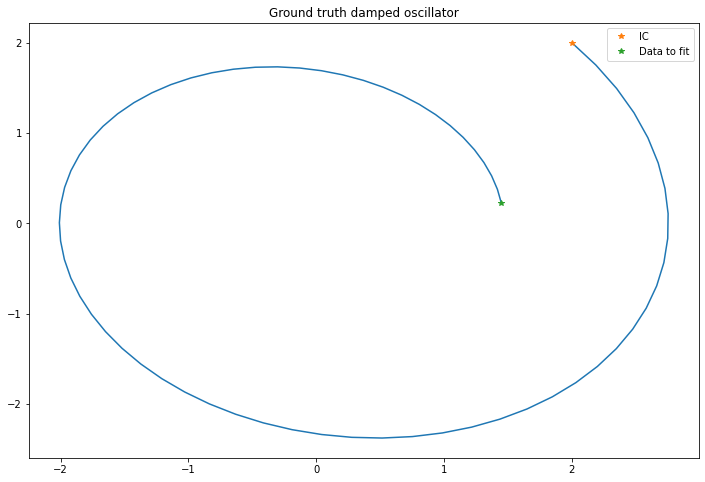

In [18]:
from example_adjoint_pytorch import generate_damped_data

x0 = [2.,2.]
T = np.arange(0,7,0.1)
k_gt = 1
gamma_gt = 0.2

data,xf = generate_damped_data(k_gt,gamma_gt,T,x0)


## Writing the training loop and preparing data

In [21]:
from example_adjoint_pytorch import forward_pass,backward_pass,make_grads_numpy,make_system,make_numpy

indices_data = [-1]

xdata =data[indices_data]

x0 = torch.tensor(x0).view(1,-1)

T = torch.tensor(T)

epochs = 60

register = {"outs": [],
            "grads": []}

system, params = make_system()

def train_loop(T,xdata,indices_data, x0, epochs, register,system, params):
    

    optim = torch.optim.Adam([params["gamma"]],lr = 0.01)

    xdata = torch.tensor(xdata)
    
    for i in range(epochs):
        optim.zero_grad()

        out = forward_pass(x0, T, system)
        
        xpred = torch.cat([out[i] for i in indices_data], dim = 0)
        
       
        loss = backward_pass(xpred, xdata)
        
        optim.step()

        if i%10==0:
            print("{}  {}".format(i,loss))

        if i%1==0:
            with torch.no_grad():
                
                _out = torch.cat(out, dim = 0)
                
                _out = make_numpy(_out[1:])
                
                _grads = make_grads_numpy(out[1:])
                
                register["outs"].append(_out)
                register["grads"].append(_grads)
    

## Training

In [22]:
train_loop(T, xdata, indices_data ,x0, epochs, register,system, params)

0  0.8086097988661843
10  0.14587700747908133
20  0.0087924308328691
30  0.0010968663266275184
40  0.004683373183579694
50  0.003356990785891164


## Plot training

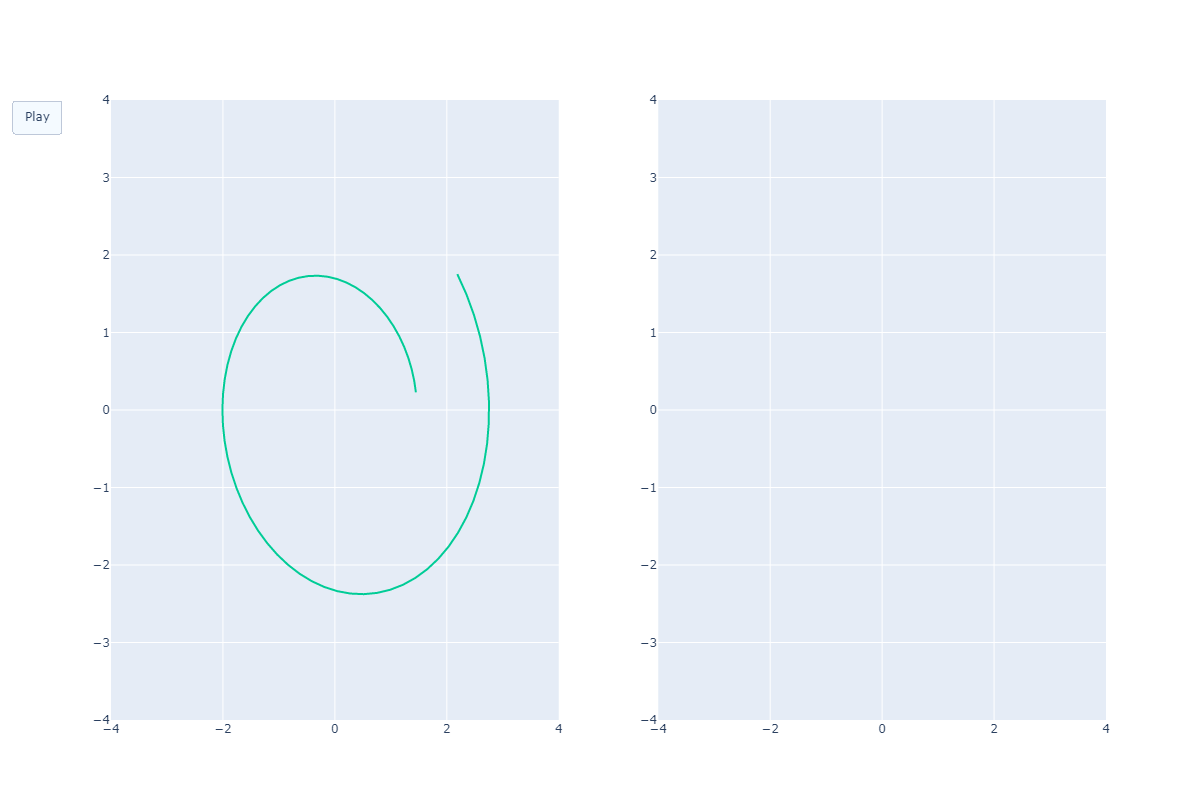

In [24]:
from example_adjoint_pytorch import training_plot

fig = training_plot(data,register)

fig.show()

## Forward Backward pass visualization

### Training data at the end of trajectory

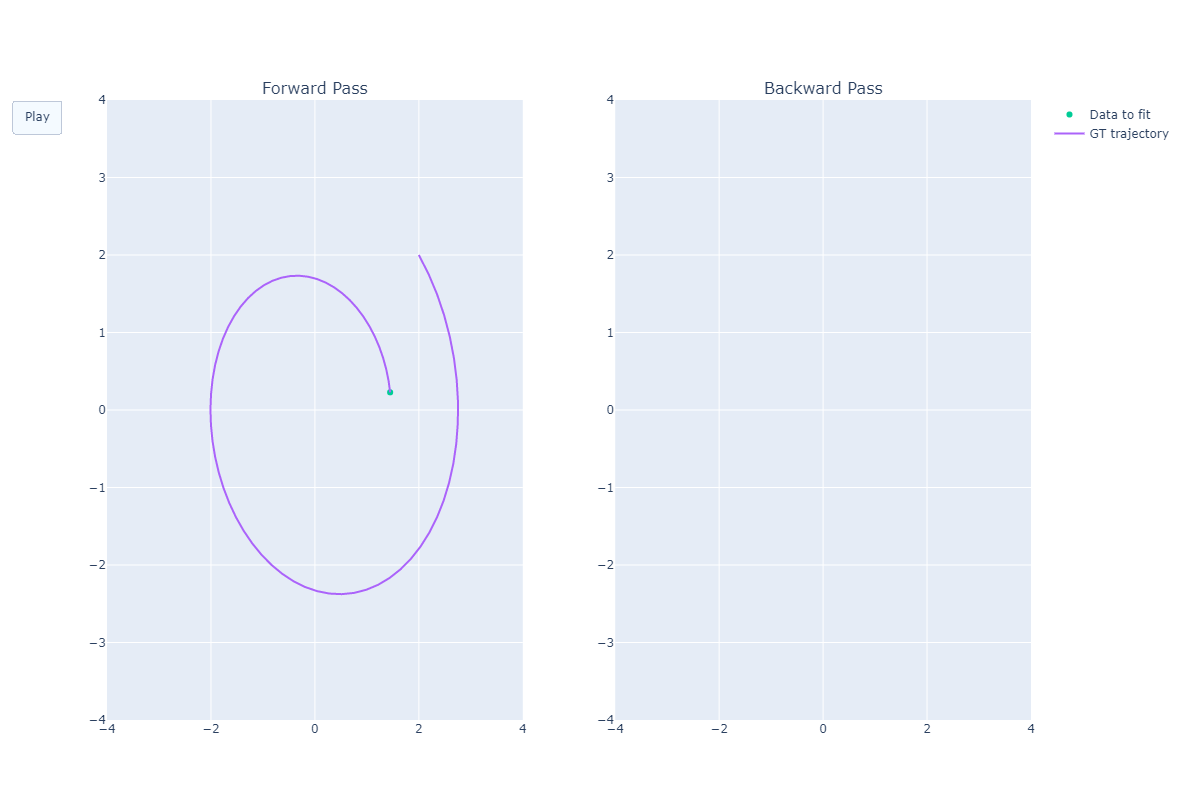

In [34]:
from example_adjoint_pytorch import make_figure_fwd_bwd

fig = make_figure_fwd_bwd(x0,T,data, [-1])
fig.show()

## Training data at the end and the middle, adjoint discontinuities 

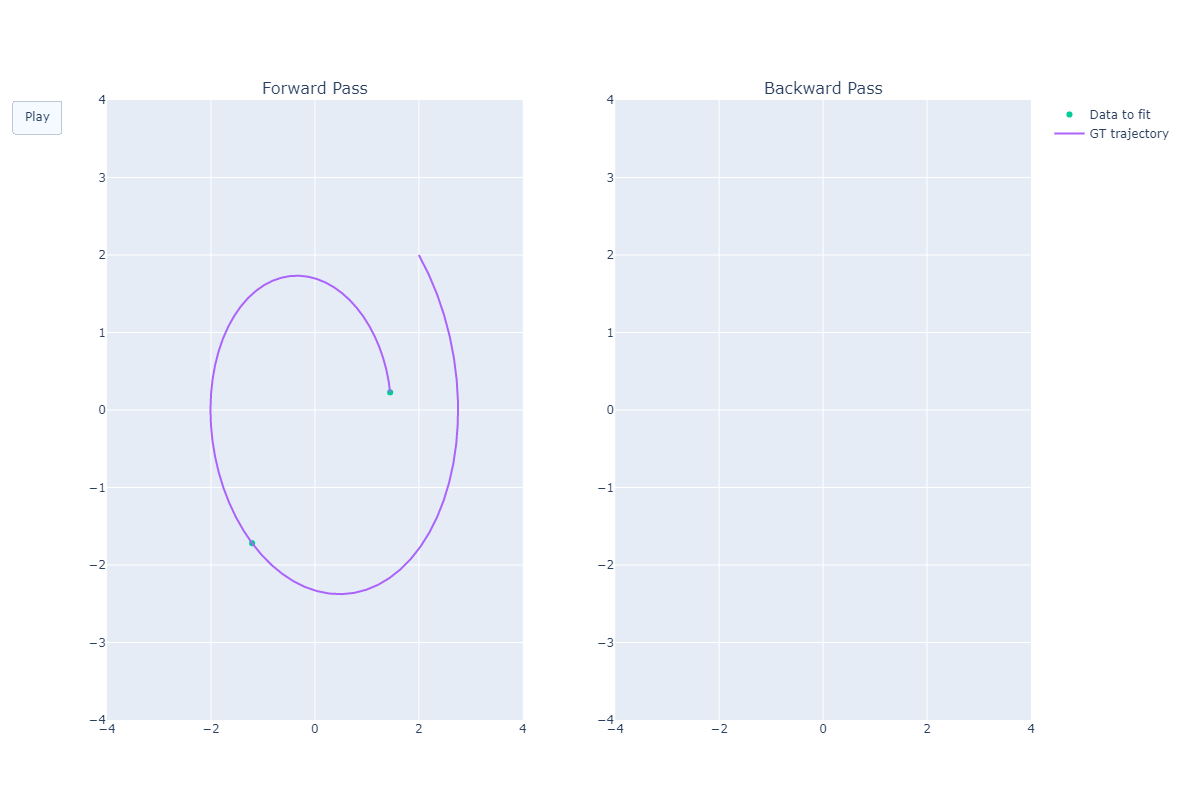

In [33]:
fig = make_figure_fwd_bwd(x0,T,data, [30,-1])
fig.show()

## Resnets 

[Deep Residual Learning for Image Recognition](https://en.wikipedia.org/wiki/Residual_neural_network)

[ResNet with one-neuron hidden layers is a Universal Approximator](https://arxiv.org/abs/1806.10909)

[Multi-level Residual Networks from Dynamical Systems View](https://arxiv.org/abs/1710.10348)

### Building block

<img src="./media/residualunit.png">

## Resnet benefits, basic example regression

### Basic resnet torch model

In [54]:
class ResNetBlock(torch.nn.Module):
    def __init__(self,width, weight = 1):
        
        super().__init__()        
        self.layer = torch.nn.Linear(width,width)
        self._weight = weight
    
    def forward(self,x):
        
        _x = torch.relu(self.layer(x))
     
        out = _x+self._weight*x
        
        return out

class Resnet(torch.nn.Module):
    def __init__(self,n_blocks,width,weight,in_features,out_features):
        
        super().__init__()
        
        layers = []
        
        in_layer = torch.nn.Linear(in_features, width)
        layers.append(in_layer)
        
        for block in range(n_blocks):
            layers.append(ResNetBlock(width,weight))
        
        out_layer = torch.nn.Linear(width, out_features)
        layers.append(out_layer)
        
        self._layers = torch.nn.ModuleList(layers)
    
    def forward(self,x):
        
        x = torch.relu(self._layers[0](x))
        
        for layer in self._layers[1:-1]:
            x = torch.relu(layer(x))
        
        out = self._layers[-1](x)
        
        return out

### Training 

In [60]:
def training_loop_rn(x,y, resnet):
    
    optim = torch.optim.Adam(resnet.parameters(),lr = 1e-2)

    for i in range(2000):
        optim.zero_grad()

        out = resnet(x)

        loss = torch.mean(torch.square(out-y))

        loss.backward()

        optim.step()

        if i%600==0:
            print(loss)

    return out  

In [69]:
#### DATA
x = torch.arange(0,1,0.01).view(-1,1)
y = torch.sin(4*x)

#### WITH RESIDUAL CONNECTIONS####

n_blocks = 20
width = 4
weight = 1
in_features = 1
out_features = 1

resnet = Resnet(n_blocks,width,weight,in_features,out_features)

out_res = training_loop_rn(x,y,resnet)



#### WITHOUT RESIDUAL CONNECTIONS (WEIGHT = 0) #####

n_blocks = 20
width = 4
weight = 0
in_features = 1
out_features = 1

resnet = Resnet(n_blocks,width,weight,in_features,out_features)

out_no_res = training_loop_rn(x,y,resnet)

tensor(756.2253, grad_fn=<MeanBackward0>)
tensor(0.1852, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.3015, grad_fn=<MeanBackward0>)
tensor(0.2613, grad_fn=<MeanBackward0>)
tensor(0.2613, grad_fn=<MeanBackward0>)
tensor(0.2613, grad_fn=<MeanBackward0>)


### Plot inference

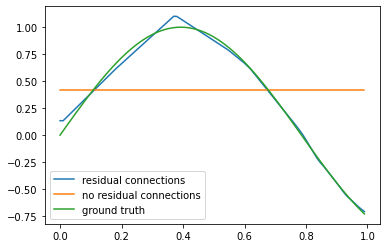

In [70]:
plt.plot(x.detach().numpy(),out_res.detach().numpy(),label="residual connections")
plt.plot(x.detach().numpy(),out_no_res.detach().numpy(),label = "no residual connections")

plt.plot(x.detach().numpy(),y.detach().numpy(),label = "ground truth")
plt.legend()

### Key insights observed in resnets
<ol>
<li>L2 norm of residuals decrease as depth increases</li>
<li>Numerical integration stencils used as connection residuals are helpful</li>
<li>Elimination of blocks on inference  degrades inference gradually</li>
</ol>

## Odenet

\begin{equation}
J(x,p) = \int_{0}^{T} \sum_{i}^{{Ndata}}f(x_{Data},x(t=T,p,x_{input}))\delta(T) dt
\end{equation}

\begin{array}{l}
 g(x,\dot{x},t,p) = \dot{x}-A(x,p,t) = 0 \\
 g_{0}(x_{input},p) = x(t = 0)-x_{input} = 0
 \end{array}

\begin{array}{lc}
\mbox{general backward/adjoint system} & \begin{cases} 
       \dot{\lambda(\tau)}\partial_{\dot{x}}g - \lambda(\tau)\dot{\partial_{\dot{x}}}g + \lambda(\tau)\partial_{x}g = -\partial_{x}f  \\
     \lambda(\tau = 0) = 0 \\
      \mu=\lambda\partial_{\dot{x}}g\partial_{x}g_{0}^{-1}
   \end{cases} \\
\end{array}

\begin{cases}
\partial_{\dot{x}}g =  \mathbb 1 \\
\dot{\partial_{\dot{x}}g} = 0 \\
\partial_{x}g = -\partial_{x}A \\
\partial_{p}g = -\partial_{p}A \\
\lambda(\tau = 0) = -\sum_{i}^{Ndata}\partial_{x}f \\
\mu= 0
\end{cases}

\begin{array}{lc}
\mbox{odenet backward/adjoint system} & \begin{cases} 
       \dot{\lambda(\tau)}  = - \lambda(\tau)\partial_{x}g   \\
     \lambda(\tau = 0) = -\sum_{i}^{Ndata}\partial_{x}f 
   \end{cases} \\
\end{array}

\begin{array}{lc}
\mbox{odenet Gradient} & \begin{equation}
 d_{p}J_{aug} = \int_{T}^{0} \lambda(t)\partial_{p}A(t)dt
 \end{equation} \\
\end{array}

### Example regression

In [71]:
from odenet import OdeNet

x = torch.rand((100,1))
y = torch.sin(8*x)*x*(1-x)

odenet = OdeNet(20,10,1,1)
optim = torch.optim.Adam(odenet.parameters())

for i in tqdm(range(500)):
    optim.zero_grad()
    out = odenet(x,eval_times = torch.arange(0,1,0.1))
    loss = torch.mean(torch.square(out-y))
    loss.backward()
    optim.step()
    if i%80==0:
        print("loss",loss)

  0%|          | 2/500 [00:00<00:38, 12.91it/s]

loss tensor(0.0168, grad_fn=<MeanBackward0>)


 17%|█▋        | 83/500 [00:07<00:39, 10.59it/s]

loss tensor(0.0123, grad_fn=<MeanBackward0>)


 33%|███▎      | 163/500 [00:14<00:31, 10.73it/s]

loss tensor(0.0050, grad_fn=<MeanBackward0>)


 49%|████▊     | 243/500 [00:21<00:23, 10.98it/s]

loss tensor(0.0002, grad_fn=<MeanBackward0>)


 64%|██████▍   | 322/500 [00:28<00:16, 10.72it/s]

loss tensor(0.0002, grad_fn=<MeanBackward0>)


 80%|████████  | 402/500 [00:35<00:08, 11.55it/s]

loss tensor(8.6188e-05, grad_fn=<MeanBackward0>)


 96%|█████████▋| 482/500 [00:42<00:01, 11.81it/s]

loss tensor(5.7428e-05, grad_fn=<MeanBackward0>)


100%|██████████| 500/500 [00:44<00:00, 11.31it/s]


In [72]:
@interact(t = (0.1,12,0.2), step = (0.1,0.5,0.02))
def plot_regression(t=1,step=0.1):
    out = odenet(x,eval_times = torch.arange(0,t,step))
    plt.plot(x.numpy(),out.detach().numpy(),'*',label = "odenet")
    plt.plot(x.numpy(),y.numpy(),'.',label = "GT")
   # plt.ylim(-0.6,1)
    plt.legend()

interactive(children=(FloatSlider(value=1.0, description='t', max=12.0, min=0.1, step=0.2), FloatSlider(value=…

## Fashion Mnist

In [150]:
dataset = torchvision.datasets.FashionMNIST("./data")
dataset_test = torchvision.datasets.FashionMNIST("./data",train = False)



dt_train = TensorDataset(dataset.train_data.view(len(dataset.train_data),1,28,28).float(),dataset.train_labels)
dt_test = TensorDataset(dataset_test.test_data.view(len(dataset_test.test_data),1,28,28).float(),dataset_test.test_labels)

<img src="./media/fashion-mnist-sprite.png">

In [152]:
from ipywidgets import interact
from odenet import conv_ode_forward,get_convode

conv = get_convode()


@interact(channel = (0,30,1), n=(1,1000,1),Tf = (0.5,10,0.1),step = (0.05,0.5,0.1))
def plot(channel = 0, n= 3, Tf = 1, step = 0.2):
    
    out = conv_ode_forward(dt_test,n,conv,Tf,step)
    
    
    fig, axes = plt.subplots(nrows = 1, ncols=len(out))
    
    fig.set_size_inches(20,12)
    
    features = out[-1]
    
    scores = conv.linear_layer(features.view(features.size(0), -1))
    probs = torch.nn.Softmax()(scores)
    
    _class = int(torch.argmax(probs).detach().numpy())
    
    _dict =  {
        0:"T-shirt",
        1:"Trouser",
        2:"Pullover",
        3:"Dress",
        4:"Coat",
        5:"Sandal",
        6:"Shirt",
        7:"Sneaker",
        8:"Bag",
        9:"Ankle boot"
    }
    

    
    out = out.detach().numpy()
    
    for i,ax in enumerate(axes):
        ax.imshow(out[i,0,channel])
        
        if i == 0:
            ax.set_title(_dict[_class])
        

interactive(children=(IntSlider(value=0, description='channel', max=30), IntSlider(value=3, description='n', m…

# Hamiltonian Neural networks

[Hamiltonian generative neural networks](https://arxiv.org/abs/1909.13789)

In [76]:
from hnn import Encoder,TransformNet,HamiltonianNet,Decoder,calculate_trajectory

In [77]:
x = torch.arange(0,1,0.01).view(-1,1)
y = torch.sin(8*x)*x*(1-x)

In [78]:
prms = {
    "e_hidden":20,
    "e_out":20,
    "t_hidden":20,
    "qp_dim":10,
    "h_hidden":20,
    "dec_hidden":20,
}

encoder = Encoder(1,prms["e_hidden"],prms["e_out"])
tnet = TransformNet(prms["e_out"],prms["t_hidden"],prms["qp_dim"])
hamiltonian_net = HamiltonianNet(prms["qp_dim"]*2,prms["h_hidden"])
decoder = Decoder(prms["qp_dim"],prms["dec_hidden"],1)


lr = 1e-2
optim_params = [
    {
        'params': encoder.parameters(),
        'lr': lr
    },
    {
        'params': tnet.parameters(),
        'lr': lr
    },
    {
        'params': hamiltonian_net.parameters(),
        'lr': lr
    },
    {
        'params':decoder.parameters(),
        'lr': lr
    },
]

optim = torch.optim.Adam(optim_params, weight_decay = 0)

In [79]:
for i in tqdm(range(400)):
    optim.zero_grad()

    nsteps = 10
    step = 0.1
    qs,ps,energies = calculate_trajectory(x,nsteps,
                            step,
                            encoder,
                            tnet,
                            hamiltonian_net)

    pred = decoder(qs)
    last = pred[:,-1,0].unsqueeze(dim=1)

    loss = torch.mean(torch.square(last-y))
    loss.backward()

    optim.step()
    if i%40==0:
        print(loss)
        
odenet = OdeNet(20,20,1,1)
optim = torch.optim.Adam(odenet.parameters(),lr = 1e-2)

for i in tqdm(range(400)):
    optim.zero_grad()
    out = odenet(x,eval_times = torch.arange(0,1,0.1))
    loss = torch.mean(torch.square(out-y))
    loss.backward()
    optim.step()
    if i%80==0:
        print("loss",loss)

  0%|          | 2/400 [00:00<00:30, 13.18it/s]

tensor(0.0277, grad_fn=<MeanBackward0>)


 10%|█         | 42/400 [00:03<00:27, 12.82it/s]

tensor(0.0068, grad_fn=<MeanBackward0>)


 21%|██        | 83/400 [00:07<00:29, 10.64it/s]

tensor(0.0001, grad_fn=<MeanBackward0>)


 31%|███       | 123/400 [00:10<00:22, 12.52it/s]

tensor(4.7703e-06, grad_fn=<MeanBackward0>)


 41%|████      | 163/400 [00:14<00:21, 11.04it/s]

tensor(5.4965e-07, grad_fn=<MeanBackward0>)


 51%|█████     | 203/400 [00:17<00:16, 11.72it/s]

tensor(3.9317e-07, grad_fn=<MeanBackward0>)


 61%|██████    | 243/400 [00:20<00:13, 11.86it/s]

tensor(3.1592e-07, grad_fn=<MeanBackward0>)


 71%|███████   | 283/400 [00:24<00:09, 11.97it/s]

tensor(2.5510e-07, grad_fn=<MeanBackward0>)


 81%|████████  | 323/400 [00:27<00:06, 12.07it/s]

tensor(2.0681e-07, grad_fn=<MeanBackward0>)


 91%|█████████ | 363/400 [00:31<00:03, 11.01it/s]

tensor(1.6834e-07, grad_fn=<MeanBackward0>)


  0%|          | 2/400 [00:00<00:44,  9.00it/s]

loss tensor(0.0179, grad_fn=<MeanBackward0>)


 20%|██        | 82/400 [00:07<00:33,  9.53it/s]

loss tensor(0.0015, grad_fn=<MeanBackward0>)


 40%|████      | 162/400 [00:16<00:27,  8.61it/s]

loss tensor(0.0001, grad_fn=<MeanBackward0>)


 60%|██████    | 242/400 [00:24<00:16,  9.48it/s]

loss tensor(7.1297e-05, grad_fn=<MeanBackward0>)


 80%|████████  | 322/400 [00:32<00:07, 10.31it/s]

loss tensor(0.0002, grad_fn=<MeanBackward0>)


100%|██████████| 400/400 [00:40<00:00,  9.96it/s]


In [80]:
from ipywidgets import interact

@interact(nsteps = (1,100,1), step= (0.05,1,0.05))
def plot(nsteps = 10, step = step):
    nsteps = nsteps
    step = step
    qs,ps,energies = calculate_trajectory(x,nsteps,
                            step,
                            encoder,
                            tnet,
                            hamiltonian_net)

    pred = decoder(qs)
    last = pred[:,-1,0].unsqueeze(dim=1)

    last = last.detach().numpy()
    
    
    Tf = step*nsteps
    out = odenet(x,eval_times = torch.arange(0,Tf,step))
    
    fig = plt.figure(figsize=(15,8))
    plt.subplot(121)
    plt.plot(x,y)
    plt.plot(x,last,'--')
    plt.subplot(122)
    plt.plot(x,y)
    plt.plot(x,out.detach().numpy(),'--')


interactive(children=(IntSlider(value=10, description='nsteps', min=1), FloatSlider(value=0.1, description='st…